# jPCA

[Churchland, Mark M., et al. "Neural population dynamics during reaching." Nature 487.7405 (2012): 51.](https://www.nature.com/articles/nature11129)

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from pylab import *

The data can be loaded with pandas :

In [9]:
data = pd.read_hdf("swr_modth.h5")

It's the responses of theta-modulated thalamic neurons to hippocampal sharp-waves ripples :

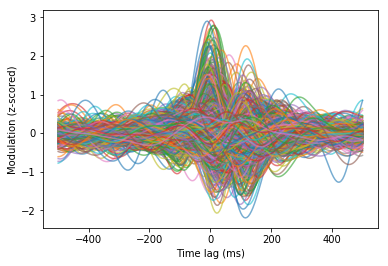

In [13]:
figure()
plot(data)
xlabel("Time lag (ms)")
ylabel("Modulation (z-scored)")
show()

There are 767 neurons here with 201 time bins. The order of the data matrix is : 

In [14]:
print(data.shape)

(201, 767)


First step is the classical PCA to reduce the dimensionality of the dataset.
Similar to the original article, I reduced it to 6 dimensions

In [18]:
n = 6
pca = PCA(n_components = n)
new_data = pca.fit_transform(data.values.T) # data needs to be inverted here depending of how you do the PCA

We can thus work on the 6 first components of the PCA

In [23]:
X = pca.components_.transpose()
times = data.index.values

We can plot the 6 components :

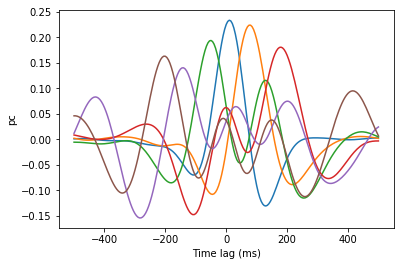

In [24]:
figure()
plot(times, X)
xlabel("Time lag (ms)")
ylabel("pc")
show()

Now we can compute $\dot{X}$ using the function written below :

In [25]:
def derivative(x, f):
    ''' 
        Compute the derivative of a time serie
        Used for jPCA
    '''
    from scipy.stats import linregress
    fish = np.zeros(len(f))
    slopes_ = []
    tmpf = np.hstack((f[0],f,f[-1])) # not circular
    binsize = x[1]-x[0]	
    tmpx = np.hstack((np.array([x[0]-binsize]),x,np.array([x[-1]+binsize])))	
    # plot(tmpx, tmpf, 'o')
    # plot(x, f, '+')
    for i in range(len(f)):
        slope, intercept, r_value, p_value, std_err = linregress(tmpx[i:i+3], tmpf[i:i+3])
        slopes_.append(slope)	
        # plot(tmpx[i:i+3], tmpx[i:i+3]*slope+intercept, '-')
    return np.array(slopes_)/binsize

The function _derivative_ is called for each component :

In [35]:
dX = np.zeros_like(X)
for i in range(n):
    dX[:,i] = derivative(times, X[:,i])

Next step is to build the H mapping using this function :

In [36]:
def buildHMap(n, ):
    '''
        build the H mapping for a given n
        used for the jPCA
    '''
    from scipy.sparse import lil_matrix
    M = np.zeros((n,n), dtype = np.int)
    M[np.triu_indices(n,1)] = np.arange(1,int(n*(n-1)/2)+1)
    M = M - M.transpose()
    m = np.vstack(M.reshape(n*n))
    k = np.vstack(M[np.triu_indices(n,1)]).astype('int')
    H = lil_matrix( (len(m), len(k)), dtype = np.float16)
    H = np.zeros( (len(m), len(k) ))
    # first column 
    for i in k.flatten():
        # positive
        H[np.where(m == i)[0][0],i-1] = 1.0
        # negative
        H[np.where(m == -i)[0][0],i-1] = -1.0
    return H

In [38]:
H = buildHMap(n)

$\tilde{X}$ is the block diagonal matrix:

In [41]:
Xtilde = np.zeros( (X.shape[0]*X.shape[1], X.shape[1]*X.shape[1]) )
for i, j in zip( (np.arange(0,n**2,n) ), np.arange(0, n*X.shape[0], X.shape[0]) ):
    Xtilde[j:j+X.shape[0],i:i+X.shape[1]] = X

We can put $\dot{X}$ in columns :

In [44]:
dXv = np.vstack(dX.transpose().reshape(X.shape[0]*X.shape[1]))

Multiply $\tilde{X}$ by $H$ :

In [46]:
XtH = np.dot(Xtilde, H)

and solve $(\tilde{X}.H).k = \dot{X}$

In [48]:
k, residuals, rank, s = np.linalg.lstsq(XtH, dXv, rcond = None)

Do $m = H.k$ to get $M_{skew}$:

In [50]:
m = np.dot(H, k)
Mskew = m.reshape(n,n).transpose()

Construct the two vectors for projection with $M_{skew}$:

In [52]:
evalues, evectors = np.linalg.eig(Mskew)
index = np.argsort(np.array([np.linalg.norm(i) for i in evalues]).reshape(int(n/2),2)[:,0])
evectors = evectors.transpose().reshape(int(n/2),2,n)

u = np.vstack([np.real(evectors[index[-1]][0] + evectors[index[-1]][1]),
                np.imag(evectors[index[-1]][0] - evectors[index[-1]][1])]).transpose()

and get the jpc vectors as $X_r = X.u$

In [53]:
rX = np.dot(X, u)

We can now look at the two jpc components :

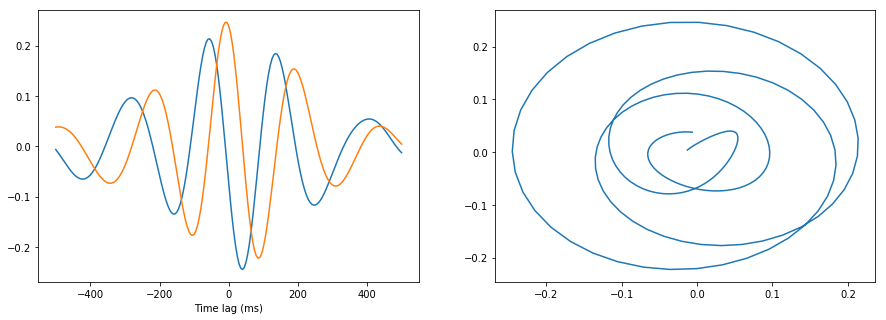

In [65]:
figure(figsize=(15, 5))
subplot(121)
plot(times, rX)
xlabel("Time lag (ms)")
subplot(122)
plot(rX[:,0], rX[:,1])
show()

We can now project the data on rX to find the swr angle :

In [58]:
score = np.dot(data.values.T, rX)
phi = np.mod(np.arctan2(score[:,1], score[:,0]), 2*np.pi)

We can now represent the sharp-waves phase for all neurons as :

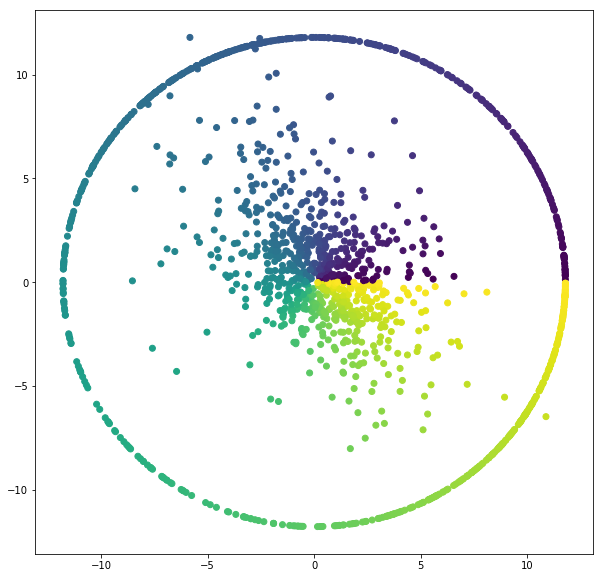

In [74]:
figure(figsize = (10,10))
scatter(score[:,0], score[:,1], c = phi)
scatter(np.cos(phi)*np.max(score), np.sin(phi)*np.max(score), c = phi)
show()